# Conditional Variational AutoEncoder


## Setup

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate, Concatenate, LSTM
import math as m
from keras.utils.vis_utils import plot_model

## Create a sampling layer

In [6]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [7]:
latent_dim = 50

X_inputs = keras.Input(shape=(1,501))
X_inputs2 = layers.Dense(128, activation="relu")(X_inputs)
X_inputs2 = layers.Dense(32, activation="relu")(X_inputs)
condit_inputs = keras.Input(shape=(1,26))
condit_inputs2 = layers.Dense(16, activation="relu")(condit_inputs)

encoder_inputs=concatenate([X_inputs2, condit_inputs2], axis=2)#concatenate functional API, Concatenate Sequential API

#encoder_inputs=Concatenate(axis=2)([X_inputs, condit_inputs])

x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
#x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
z = layers.Reshape((1,latent_dim))(z)
zc = concatenate([z, condit_inputs])
zc = layers.Reshape((latent_dim+26,))(zc)

encoder = keras.Model([X_inputs,condit_inputs], [z_mean, z_log_var, zc], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 501)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 26)]      0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 1, 32)        16064       ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 16)        432         ['input_2[0][0]']                
                                                                                            

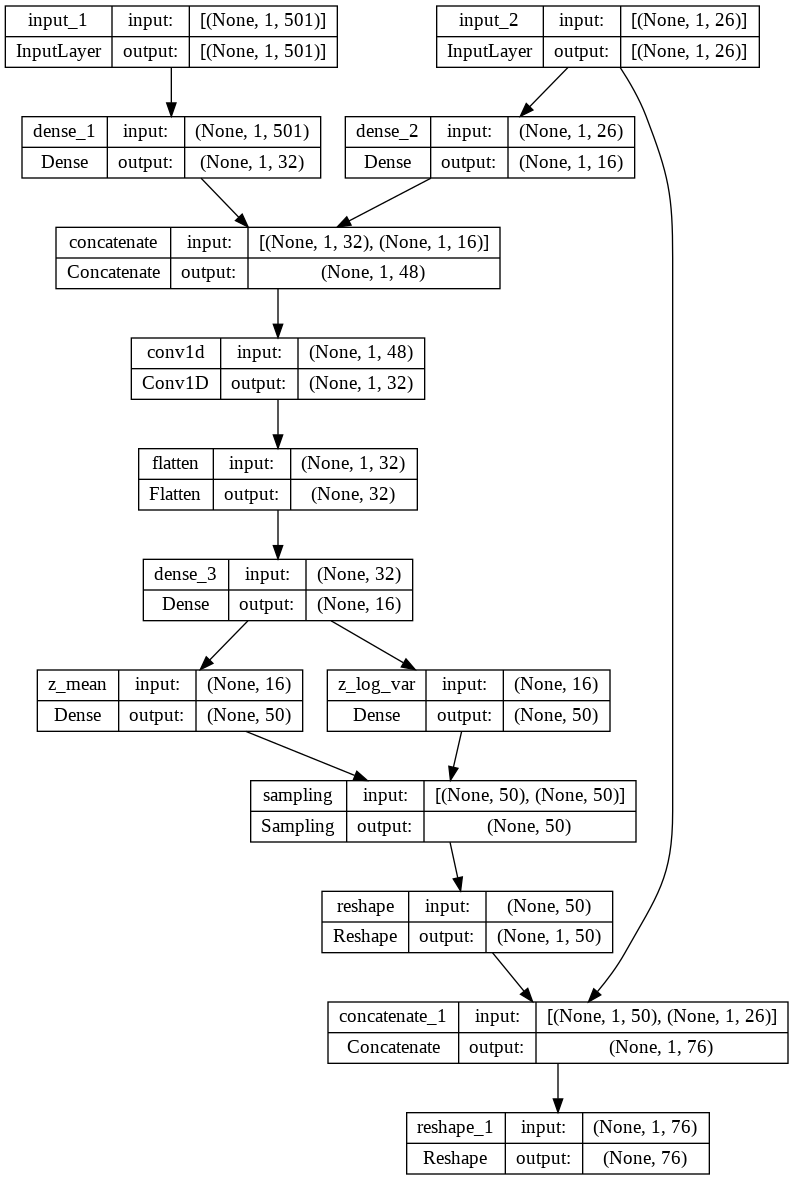

In [8]:
plot_model(encoder, show_shapes=True)

## Build the decoder

In [9]:
latent_inputs = keras.Input(shape=(latent_dim+26,))
x = layers.Dense(128 * 1, activation="relu")(latent_inputs)
x = layers.Dense(501 * 1, activation="relu")(x)
x = layers.Reshape((501, 1))(x)
#x = layers.Reshape((1, 32))(x)
#x = layers.Conv1DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
#x = layers.Flatten()(x)
#x = layers.Dense(501 * 1, activation="relu")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder_outputs = layers.Reshape((1,501))(decoder_outputs)


decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 76)]              0         
                                                                 
 dense_4 (Dense)             (None, 128)               9856      
                                                                 
 dense_5 (Dense)             (None, 501)               64629     
                                                                 
 reshape_2 (Reshape)         (None, 501, 1)            0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 501, 32)          128       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 501, 1)           97        
 ranspose)                                                 

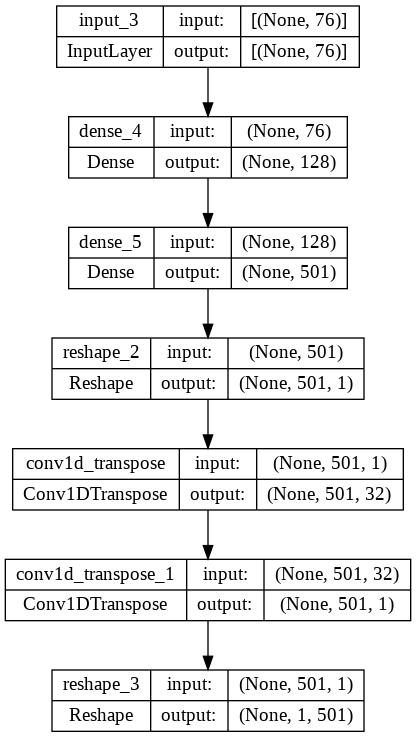

In [10]:
plot_model(decoder, show_shapes=True)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim+26,))
print(latent_inputs)
x = layers.Dense(32 * 1, activation="relu")(latent_inputs)
x = layers.Reshape((1, 32))(x)
#x = layers.Conv1DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
#x = layers.Flatten()(x)
#x = layers.Dense(501 * 1, activation="relu")(x)
#decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
#decoder_outputs = layers.Reshape((1,501))(decoder_outputs)
decoder_outputs=layers.Dense(501, activation="relu")(decoder_outputs)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 28), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28)]              0         
                                                                 
 dense_14 (Dense)            (None, 32)                928       
                                                                 
 reshape_9 (Reshape)         (None, 1, 32)             0         
                                                                 
 conv1d_transpose_6 (Conv1DT  (None, 1, 32)            3104      
 ranspose)                                                       
                                                                 
 dense_15 (Dense)            (None, 1, 501)            16533     
                                            

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.count=0
        self.epochcount=0
        self.minepochs=1000#value in which decay starts growing from 0 to 1
        self.maxepochs=self.minepochs*10#value in which decay reaches max value of 1, log function base 10: log (1)=0, log(10)=1
        #self.step_var=tf.Variable(0, dtype=tf.float64)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if self.count%118==0:
          #self.count=0
          self.epochcount+=1
        #self.step_var.assign_add(delta=1)
        #print("hehe", self.count, self.epochcount)
        with tf.GradientTape() as tape:
            #print(data.shape)#type(data)=tuple, data[0][0]=movements, data[0][1]=features 
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0][0], reconstruction)#binary crossentropy between real and created movements
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            #if self.count<=self.minepochs:#si se han hecho menos de x operaciones, peso 0, KL weight annealing
            #  weight=0
            #else:
            #  if self.count<=(self.maxepochs):#entre x y x*100, funcion logaritmica entre 0 y 1 (log base 10)
            #    weight=m.log(self.count/self.minepochs,10)
            #  else:#cuando se llega al numero maximo de operaciones, weight siempre en 1
            #    weight=1
            #kl_loss*=weight
            total_loss = reconstruction_loss + kl_loss#*(0.001/self.epochcount)#*decay, where decay varies inversely with the number of epochs
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.count+=1
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
movements=np.load('/content/drive/MyDrive/Colab Notebooks/Y_small_train.npy')
print("Movements shape", movements.shape)
feats=np.load('/content/drive/MyDrive/Colab Notebooks/X_small_train_feats.npy')
print("Features shape", feats.shape)

Movements shape (20000, 501)
Features shape (20000, 26)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
def sci_minmax(X,input_minmax_scaler=None):
        if input_minmax_scaler is None:
            input_minmax_scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
        return (input_minmax_scaler.fit_transform(X), input_minmax_scaler)
(movements, input_minmax_scaler) = sci_minmax(movements)
(feats, feats_input_minmax_scaler) = sci_minmax(feats)

In [ ]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#print(x_train.shape, x_test.shape)
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(zmnist_digits, -1).astype("float32") / 255
#print(mnist_digits.shape)

movements=movements.reshape(20000,1,501)
feats=feats.reshape(20000,1,26)
print("Movements shape", movements.shape)
print("Features shape", feats.shape)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)#para debugear
#vae.fit(mnist_digits, epochs=30, batch_size=128)
vae.fit([movements[0:15000],feats[0:15000]], epochs=300, batch_size=128)#0.00005

Movements shape (20000, 1, 501)
Features shape (20000, 1, 26)
Epoch 1/300
118/118 [==============================] - 18s 150ms/step - loss: 63.9054 - reconstruction_loss: 47.2840 - kl_loss: 0.0740
Epoch 2/300
118/118 [==============================] - 12s 105ms/step - loss: 34.0868 - reconstruction_loss: 33.4735 - kl_loss: 0.0038
Epoch 3/300
118/118 [==============================] - 12s 104ms/step - loss: 33.0400 - reconstruction_loss: 32.7280 - kl_loss: 1.6948e-04
Epoch 4/300
118/118 [==============================] - 12s 105ms/step - loss: 32.6774 - reconstruction_loss: 32.3850 - kl_loss: 4.0798e-05
Epoch 5/300
118/118 [==============================] - 12s 104ms/step - loss: 32.4449 - reconstruction_loss: 32.2127 - kl_loss: 2.1883e-05
Epoch 6/300
118/118 [==============================] - 12s 104ms/step - loss: 32.3763 - reconstruction_loss: 32.1410 - kl_loss: 1.3465e-05
Epoch 7/300
118/118 [==============================] - 12s 103ms/step - loss: 32.3142 - reconstruction_loss: 32.

In [ ]:
z_sample=np.random.uniform(0,1,size=[5000, latent_dim])
z_sample=np.concatenate((z_sample, feats.reshape(20000,26)[15000:20000,:]), axis=1)#concatenar features reales al ruido
x_decoded = vae.decoder.predict(z_sample)
print(x_decoded.shape)
x_decoded=x_decoded.reshape(5000,501)
x_decoded=input_minmax_scaler.inverse_transform(x_decoded)

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/movements_conditionalVAE_both_scaled_featslabel.npy", x_decoded)